# Binary encoding

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, DepthwiseConv2D
import tensorflow as tf

In [3]:
# Opciones de decodificación para otros parámetros
layer_type_options = {
    0: 'Conv2D', 
    1: 'BatchNorm', 
    2: 'MaxPooling', 
    3: 'Dropout', 
    4: 'Dense', 
    5: 'Flatten',
    6: 'DepthwiseConv2D',  
    7: 'DontCare',  
    8: 'Repetition'
}
stride_options = {0: 1, 1: 2}
dropout_options = {0: 0.2, 1: 0.3, 2: 0.4, 3: 0.5}
activation_options = {0: 'relu', 1: 'leaky_relu', 2: 'sigmoid', 3: 'tanh'}

# Función para codificar los parámetros de la capa
def encode_layer_params(layer_type_idx, param1=0, param2=0, param3=0):
    """
    Codifica una capa en una lista en función del tipo de capa y sus parámetros.
    
    layer_type_idx : int : índice del tipo de capa según layer_type_options.
    param1         : int/float : filtros, neuronas, capas de repetición, etc.
    param2         : int : stride, número de repeticiones, etc.
    param3         : int : índice de activación o tasa de dropout.
    """
    return [layer_type_idx, param1, param2, param3]

# Función para decodificar los parámetros de la capa
def decode_layer_params(encoded_params):
    """
    Decodifica una capa desde su representación codificada en parámetros interpretables.
    
    encoded_params : list : [tipo de capa, param1, param2, param3].
    """
    layer_type_idx = encoded_params[0]
    layer_type = layer_type_options.get(layer_type_idx, 'DontCare')
    
    # Decodificar en función del tipo de capa
    if layer_type in ['Conv2D', 'DepthwiseConv2D']:
        filters = max(4, min(encoded_params[1], 32))  # Limitar filtros entre 4 y 32
        strides = stride_options.get(encoded_params[2], 1)
        activation = activation_options.get(encoded_params[3], 'relu')
        return {
            'type': layer_type,
            'filters': filters,
            'strides': strides,
            'activation': activation
        }
    elif layer_type == 'BatchNorm':
        return {'type': 'BatchNorm'}
    elif layer_type == 'MaxPooling':
        strides = stride_options.get(encoded_params[1], 1)
        return {'type': 'MaxPooling', 'strides': strides}
    elif layer_type == 'Dropout':
        rate = dropout_options.get(encoded_params[1], 0.2)
        return {'type': 'Dropout', 'rate': rate}
    elif layer_type == 'Dense':
        units = max(1, min(encoded_params[1], 512))  # Limitar unidades entre 1 y 512
        activation = activation_options.get(encoded_params[2], 'relu')
        return {'type': 'Dense', 'units': units, 'activation': activation}
    elif layer_type == 'Flatten':
        return {'type': 'Flatten'}
    elif layer_type == 'Repetition':
        return {
            'type': 'Repetition',
            'repetition_layers': int(encoded_params[1]),
            'repetition_count': int(encoded_params[2])
        }
    elif layer_type == 'DontCare':
        return {'type': "DontCare"}

    return None

# Ejemplos de codificación y decodificación
encoded_conv2d = encode_layer_params(0, 16, 0, 0)  # Conv2D con 16 filtros, stride 1 y activación ReLU
decoded_conv2d = decode_layer_params(encoded_conv2d)
print(f"\nCodificación real de Conv2D: {encoded_conv2d}")
print(f"Decodificación Conv2D: {decoded_conv2d}")

encoded_dropout = encode_layer_params(3, 1)  # Dropout con tasa de 0.3
decoded_dropout = decode_layer_params(encoded_dropout)
print(f"\nCodificación real de Dropout: {encoded_dropout}")
print(f"Decodificación Dropout: {decoded_dropout}")

encoded_dense = encode_layer_params(4, 128, 0)  # Dense con 128 neuronas y activación ReLU
decoded_dense = decode_layer_params(encoded_dense)
print(f"\nCodificación real de Dense: {encoded_dense}")
print(f"Decodificación Dense: {decoded_dense}")

encoded_repetition = encode_layer_params(8, 3, 5)  # Repetition para repetir las últimas 3 capas 5 veces
decoded_repetition = decode_layer_params(encoded_repetition)
print(f"\nCodificación real de Repetition: {encoded_repetition}")
print(f"Decodificación Repetition: {decoded_repetition}")



Codificación real de Conv2D: [0, 16, 0, 0]
Decodificación Conv2D: {'type': 'Conv2D', 'filters': 16, 'strides': 1, 'activation': 'relu'}

Codificación real de Dropout: [3, 1, 0, 0]
Decodificación Dropout: {'type': 'Dropout', 'rate': 0.3}

Codificación real de Dense: [4, 128, 0, 0]
Decodificación Dense: {'type': 'Dense', 'units': 128, 'activation': 'relu'}

Codificación real de Repetition: [8, 3, 5, 0]
Decodificación Repetition: {'type': 'Repetition', 'repetition_layers': 3, 'repetition_count': 5}


## Complete archs


In [4]:
# Clase para capas neutrales 'DontCare'
class DontCareLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DontCareLayer, self).__init__()

    def call(self, inputs):
        return inputs

In [5]:
def encode_model_architecture(model_dict, max_alleles=48):
    """
    Codifica la arquitectura del modelo en una lista de valores con un máximo de `max_alleles`.
    Cada capa se codifica en función de sus parámetros.
    """
    encoded_layers = []
    total_alleles = 0

    for layer in model_dict['layers']:
        if layer['type'] == 'Repetition':  # Codificar capa de repetición
            encoded_layer = encode_layer_params(
                layer_type_idx=8,  # índice para 'Repetition'
                param1=layer.get('repetition_layers', 0),
                param2=layer.get('repetition_count', 1)
            )
        else:
            layer_type_idx = next(
                key for key, value in layer_type_options.items() if value == layer['type']
            )
            
            # Codificar parámetros específicos de cada tipo de capa
            if layer['type'] in ['Conv2D', 'DepthwiseConv2D']:  
                # Limitar filtros dentro del rango [4, 32]
                param1 = max(4, min(layer.get('filters', 8), 32))  
                param2 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                param3 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, param3]

            elif layer['type'] == 'Dense':
                # Limitar neuronas dentro del rango [1, 512]
                param1 = max(1, min(layer.get('units', 1), 512))
                param2 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, 0]

            elif layer['type'] == 'MaxPooling':
                param1 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'Dropout':
                param1 = next((key for key, value in dropout_options.items() if value == layer.get('rate', 0.2)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'BatchNorm':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'Flatten':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'DontCare':
                encoded_layer = [layer_type_idx, 0, 0, 0]

        # Añadir la codificación de la capa a la lista de alelos
        encoded_layers.extend(encoded_layer)
        total_alleles += len(encoded_layer)

    # Rellenar con 'DontCare' si el total de alelos es menor que `max_alleles`
    while total_alleles < max_alleles:
        dont_care_encoding = encode_layer_params(7)  # índice de 'DontCare'
        encoded_layers.extend(dont_care_encoding)
        total_alleles += len(dont_care_encoding)

    # Recortar si excede `max_alleles`
    final_encoding = encoded_layers[:max_alleles]
    print(f"Final Encoded Model: {final_encoding}")
    
    return final_encoding


In [6]:
import random

def fixArch(encoded_model, verbose=False):
    """
    Corrige la arquitectura codificada del modelo, asegurando que:
    - Se evite la presencia de capas incompatibles después de una capa Flatten.
    - En caso de una capa de Repetition, se ajuste el alcance de repetición si no hay suficientes capas anteriores.

    Parameters:
        encoded_model (list): Lista codificada de la arquitectura del modelo.
        verbose (bool): Si es True, muestra las correcciones realizadas.

    Returns:
        list: Lista con la arquitectura corregida, truncada a un máximo de 48 alelos.
    """

    fixed_layers = []  # Lista que almacenará la arquitectura corregida
    input_is_flattened = False  # Indicador para saber si ya hay una capa Flatten en el modelo
    index = 0  # Índice para recorrer el modelo codificado

    # Procesar cada capa en el modelo sin forzar la primera capa a ser específica
    while index < len(encoded_model) and len(fixed_layers) < 48:
        layer_type = int(encoded_model[index])  # Obtener el tipo de capa actual

        # Procesar la capa de Repetition
        if layer_type == 8:
            repetition_layers = int(encoded_model[index + 1])  # Número de capas a repetir
            repetition_count = min(max(int(encoded_model[index + 2]), 0), 32)  # Cantidad de repeticiones

            # Verificar si hay suficientes capas para la repetición solicitada
            actual_layers_to_repeat = min(repetition_layers, len(fixed_layers) // 4)

            if actual_layers_to_repeat != repetition_layers:
                if verbose:
                    print(f"Ajustando alcance de repetición de {repetition_layers} a {actual_layers_to_repeat} debido a falta de capas.")
                repetition_layers = actual_layers_to_repeat

            # Añadir la capa de repetición sin modificar su estructura
            fixed_layers.extend([layer_type, repetition_layers, repetition_count, 0])
            index += 4
            continue

        # Procesar cada tipo de capa normal con sus restricciones
        if layer_type == 0:  # Conv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 6:  # DepthwiseConv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 2:  # MaxPooling
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                stride_idx = min(max(int(encoded_model[index + 1]), 0), 1)
                fixed_layers.extend([layer_type, stride_idx, 0, 0])

        elif layer_type == 3:  # Dropout
            rate_idx = min(max(int(encoded_model[index + 1]), 0), 3)
            fixed_layers.extend([layer_type, rate_idx, 0, 0])

        elif layer_type == 4:  # Dense
            # Limitar el número de neuronas entre 1 y 512
            neurons = min(max(int(encoded_model[index + 1]), 1), 512)
            activation_idx = min(max(int(encoded_model[index + 2]), 0), 3)
            fixed_layers.extend([layer_type, neurons, activation_idx, 0])

        elif layer_type == 1:  # BatchNorm
            fixed_layers.extend([layer_type, 0, 0, 0])

        elif layer_type == 5:  # Flatten
            if len(fixed_layers) < 16:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            elif input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                fixed_layers.extend([layer_type, 0, 0, 0])
                input_is_flattened = True  # Marcar que ya hay un Flatten

        elif layer_type == 7:  # DontCare
            fixed_layers.extend([layer_type, 0, 0, 0])

        else: # DontCare
          fixed_layers.extend([7, 0, 0, 0])

        index += 4  # Avanzar al siguiente grupo de parámetros

    return fixed_layers[:48]  # Limitar a 48 alelos


In [7]:
# Ejecutar ejemplos de prueba para la función fixArch con arquitecturas de 12 capas (48 valores en total)

# Ejemplo 1: Arquitectura sin Flatten antes de Dense y con capas adicionales
encoded_model_1 = [
    0, 3, 0, 0,    # Conv2D, 32 filtros, stride 1, activación relu
    2, 1, 0, 0,    # MaxPooling, stride 2
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu (sin Flatten antes)
    7, 0, 0, 0,    # DontCare
    1, 0, 0, 0,    # BatchNorm
    3, 2, 0, 0,    # Dropout, tasa 0.4
    0, 1, 1, 0,    # Conv2D, 16 filtros, stride 2, activación relu
    6, 1, 1, 0,    # DepthwiseConv2D, 16 filtros, stride 2, activación relu
    5, 0, 0, 0,    # Flatten
    4, 3, 2, 0,    # Dense, 256 neuronas, activación sigmoid
    4, 1, 3, 0,    # Dense, 32 neuronas, activación tanh
    4, 1, 2, 0     # Dense, 32 neuronas, activación sigmoid
]

# Ejemplo 2: Arquitectura con Flatten al inicio (inválido) y sin Dense al final
encoded_model_2 = [
    5, 0, 0, 0,    # Flatten (inválido al inicio)
    0, 2, 1, 1,    # Conv2D, 30 filtros, stride 2, activación leaky_relu
    2, 1, 0, 0,    # MaxPooling, stride 2
    3, 1, 0, 0,    # Dropout, tasa 0.3
    1, 0, 0, 0,    # BatchNorm
    0, 1, 0, 0,    # Conv2D, 16 filtros, stride 1, activación relu
    6, 2, 1, 0,    # DepthwiseConv2D, 30 filtros, stride 2, activación relu
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu
    3, 0, 0, 0,    # Dropout, tasa 0.2
    1, 0, 0, 0,    # BatchNorm
    4, 3, 3, 0,    # Dense, 256 neuronas, activación tanh
    7, 0, 0, 0     # DontCare
]

# Ejemplo 3: Arquitectura con Repetition y sin Dense al final
encoded_model_3 = [
    0, 1, 0, 0,    # Conv2D, 16 filtros, stride 1, activación relu
    8, 2, 2, 0,    # Repetition, repite las últimas 2 capas 2 veces
    5, 0, 0, 0,    # Flatten
    2, 1, 0, 0,    # MaxPooling, stride 2
    3, 1, 0, 0,    # Dropout, tasa 0.3
    6, 2, 1, 0,    # DepthwiseConv2D, 30 filtros, stride 2, activación relu
    0, 3, 0, 1,    # Conv2D, 32 filtros, stride 1, activación leaky_relu
    1, 0, 0, 0,    # BatchNorm
    5, 0, 0, 0,    # Flatten
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu
    7, 0, 0, 0,    # DontCare
    3, 2, 0, 0     # Dropout, tasa 0.4
]

# Ejemplo 4: Arquitectura con parámetros fuera de límite
encoded_model_4 = [
    0, 4, 2, 1,    # Conv2D, 64 filtros (fuera de límite), stride 2, activación leaky_relu
    3, 5, 0, 0,    # Dropout, tasa 0.6 (fuera de límite)
    4, 5, 3, 0,    # Dense, 512 neuronas (fuera de límite), activación sigmoid
    6, 4, 2, 0,    # DepthwiseConv2D, 64 filtros (fuera de límite), stride 2, activación relu
    1, 0, 0, 0,    # BatchNorm
    3, 3, 0, 0,    # Dropout, tasa 0.5
    5, 0, 0, 0,    # Flatten
    2, 1, 0, 0,    # MaxPooling, stride 2
    0, 1, 0, 0,    # Conv2D, 16 filtros, stride 1, activación relu
    4, 3, 1, 0,    # Dense, 256 neuronas, activación leaky_relu
    7, 0, 0, 0,    # DontCare
    4, 1, 2, 0     # Dense, 32 neuronas, activación sigmoid
]
# Ejemplo 5: Arquitectura con capa de Repetition que repite las últimas capas
encoded_model_5 = [
    0, 2, 1, 0,    # Conv2D, 30 filtros, stride 2, activación relu
    8, 2, 3, 0,    # Repetition, repite las últimas 2 capas 3 veces
    5, 0, 0, 0,    # Flatten
    2, 1, 0, 0,    # MaxPooling, stride 2
    3, 1, 0, 0,    # Dropout, tasa 0.3
    6, 2, 1, 0,    # DepthwiseConv2D, 30 filtros, stride 2, activación relu
    0, 3, 0, 1,    # Conv2D, 32 filtros, stride 1, activación leaky_relu
    1, 0, 0, 0,    # BatchNorm
    5, 0, 0, 0,    # Flatten
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu
    7, 0, 0, 0,    # DontCare
    3, 2, 0, 0     # Dropout, tasa 0.4
]

# Lista de modelos para probar
model_examples = [encoded_model_1, encoded_model_2, encoded_model_3, encoded_model_4, encoded_model_5]

# Ejecución de pruebas
for i, model in enumerate(model_examples, 1):
    print(f"\n--- Ejemplo {i} ---")
    fixed_model = fixArch(model, verbose=True)
    print(f"Modelo Original: {len(model)} alelos\n{model}") 
    print(f"Modelo Corregido: {len(fixed_model)} alelos\n{fixed_model}")



--- Ejemplo 1 ---
Modelo Original: 48 alelos
[0, 3, 0, 0, 2, 1, 0, 0, 4, 2, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 3, 2, 0, 0, 0, 1, 1, 0, 6, 1, 1, 0, 5, 0, 0, 0, 4, 3, 2, 0, 4, 1, 3, 0, 4, 1, 2, 0]
Modelo Corregido: 48 alelos
[0, 4, 0, 0, 2, 1, 0, 0, 4, 2, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 3, 2, 0, 0, 0, 4, 1, 0, 6, 4, 1, 0, 5, 0, 0, 0, 4, 3, 2, 0, 4, 1, 3, 0, 4, 1, 2, 0]

--- Ejemplo 2 ---
Modelo Original: 48 alelos
[5, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 6, 2, 1, 0, 4, 2, 1, 0, 3, 0, 0, 0, 1, 0, 0, 0, 4, 3, 3, 0, 7, 0, 0, 0]
Modelo Corregido: 48 alelos
[7, 0, 0, 0, 0, 4, 1, 1, 2, 1, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 6, 4, 1, 0, 4, 2, 1, 0, 3, 0, 0, 0, 1, 0, 0, 0, 4, 3, 3, 0, 7, 0, 0, 0]

--- Ejemplo 3 ---
Ajustando alcance de repetición de 2 a 1 debido a falta de capas.
Modelo Original: 48 alelos
[0, 1, 0, 0, 8, 2, 2, 0, 5, 0, 0, 0, 2, 1, 0, 0, 3, 1, 0, 0, 6, 2, 1, 0, 0, 3, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 2, 1, 0, 7, 0, 0, 0, 3, 2, 0, 0]
Modelo Corregid

In [8]:
def decode_model_architecture(encoded_model):
    """
    Decodifica la arquitectura del modelo a partir de la lista codificada de valores (índices),
    aplicando las reglas de repetición y asegurando la inclusión de una capa convolucional inicial.
    """
    model_dict = {'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}]}  # Inserta Conv2D inicial
    index = 0

    while index < len(encoded_model):
        layer_type = int(encoded_model[index])
        param1 = encoded_model[index + 1]
        param2 = encoded_model[index + 2]
        param3 = encoded_model[index + 3]

        if layer_type == 8:  # Capa de Repetition
            repetition_layers = int(param1)
            repetition_count = int(param2)
            # Selecciona solo el grupo válido de capas para la repetición
            layers_to_repeat = select_group_for_repetition(model_dict['layers'], repetition_layers)
            
            if len(layers_to_repeat) > 0:
                for _ in range(repetition_count):
                    model_dict['layers'].extend(layers_to_repeat)

        else:
            decoded_layer = {}

            if layer_type == 0:  # Conv2D
                decoded_layer = {
                    'type': 'Conv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 6:  # DepthwiseConv2D
                decoded_layer = {
                    'type': 'DepthwiseConv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 2:  # MaxPooling
                decoded_layer = {
                    'type': 'MaxPooling',
                    'strides': stride_options.get(param1, 1)
                }
            elif layer_type == 3:  # Dropout
                decoded_layer = {
                    'type': 'Dropout',
                    'rate': dropout_options.get(param1, 0.2)
                }
            elif layer_type == 4:  # Dense
                decoded_layer = {
                    'type': 'Dense',
                    'units': max(1, min(param1, 512)),  # Limita `units` entre 1 y 512
                    'activation': activation_options.get(param2, 'relu')
                }
            elif layer_type == 1:  # BatchNorm
                decoded_layer = {'type': 'BatchNorm'}
            elif layer_type == 5:  # Flatten
                decoded_layer = {'type': 'Flatten'}
            elif layer_type == 7:  # DontCare
                decoded_layer = {'type': 'DontCare'}

            model_dict['layers'].append(decoded_layer)

        index += 4

    # Asegura que haya una capa Flatten antes de la capa Dense final, si no ya existe una Flatten
    if model_dict['layers'][-1]['type'] != 'Flatten':
        model_dict['layers'].append({'type': 'Flatten'})
        
    # Añade la capa Dense final obligatoria
    model_dict['layers'].append({'type': 'Dense', 'units': 1, 'activation': 'sigmoid'})

    return model_dict

def select_group_for_repetition(layers, repetition_layers):
    """
    Selecciona el primer grupo válido para repetición en función de las reglas de compatibilidad.

    Parameters:
        layers (list): Lista de capas ya procesadas, donde cada capa es un diccionario.
        repetition_layers (int): Número de capas hacia atrás para considerar en la repetición.

    Returns:
        list: Lista de capas compatibles para repetición.
    """
    valid_layers = []
    group_type = None

    # Retrocede desde el final de `layers` para encontrar el grupo válido
    for layer in reversed(layers[-repetition_layers:]):
        if group_type is None:
            # Determina el tipo de grupo
            if layer['type'] in ['Flatten', 'Dense']:
                group_type = 'dense'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling']:
                group_type = 'convolutional'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['BatchNorm', 'DontCare']:  # BatchNorm y DontCare son compatibles con ambos grupos
                valid_layers.insert(0, layer)
        else:
            # Agrega solo capas compatibles con el grupo seleccionado
            if group_type == 'dense' and layer['type'] in ['Flatten', 'Dense', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)
            elif group_type == 'convolutional' and layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)

    return valid_layers


In [9]:
# Reparar cada ejemplo con fixArch y luego decodificar con decode_model_architecture
repaired_and_decoded_models = []

for i, encoded_model in enumerate([encoded_model_1, encoded_model_2, encoded_model_3, encoded_model_4, encoded_model_5], 1):
    # Reparar el modelo
    repaired_model = fixArch(encoded_model, verbose=True)
    # Decodificar el modelo reparado
    decoded_model = decode_model_architecture(repaired_model)
    # Guardar el modelo decodificado
    repaired_and_decoded_models.append(decoded_model)
    print(f"\n--- Modelo {i} Decodificado ---")
    print(decoded_model)

# Opcional: Mostrar todos los modelos decodificados juntos
print("\n--- Todos los Modelos Decodificados ---")
for i, model in enumerate(repaired_and_decoded_models, 1):
    print(f"Modelo {i} Decodificado:", model)


--- Modelo 1 Decodificado ---
{'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}, {'type': 'Conv2D', 'filters': 4, 'strides': 1, 'activation': 'relu'}, {'type': 'MaxPooling', 'strides': 2}, {'type': 'Dense', 'units': 2, 'activation': 'leaky_relu'}, {'type': 'DontCare'}, {'type': 'BatchNorm'}, {'type': 'Dropout', 'rate': 0.4}, {'type': 'Conv2D', 'filters': 4, 'strides': 2, 'activation': 'relu'}, {'type': 'DepthwiseConv2D', 'filters': 4, 'strides': 2, 'activation': 'relu'}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 3, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 1, 'activation': 'tanh'}, {'type': 'Dense', 'units': 1, 'activation': 'sigmoid'}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 1, 'activation': 'sigmoid'}]}

--- Modelo 2 Decodificado ---
{'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}, {'type': 'DontCare'}, {'type': 'Conv2D', 'filters': 4, 'strides': 2, 'activation': 'leaky_relu'}, {'type': 'MaxPo

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D



def build_tf_model_from_dict(model_dict, input_shape=(28, 28, 3)):
    """
    Construye un modelo de TensorFlow a partir de un diccionario JSON expandido.
    """
    print("\nConstruyendo el modelo en TensorFlow desde el JSON expandido...")
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for layer in model_dict['layers']:
        if layer['type'] == 'Conv2D':
            model.add(Conv2D(filters=layer['filters'], kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))
        
        elif layer['type'] == 'DepthwiseConv2D':
            model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))
        
        elif layer['type'] == 'BatchNorm':
            model.add(BatchNormalization())
        
        elif layer['type'] == 'MaxPooling':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=int(layer['strides']), padding='same'))
        
        elif layer['type'] == 'Flatten':
            model.add(Flatten())
        
        elif layer['type'] == 'Dense':
            model.add(Dense(units=int(layer['units']), activation=layer['activation']))
        
        elif layer['type'] == 'Dropout':
            model.add(Dropout(rate=layer['rate']))
        
        elif layer['type'] == 'DontCare':
            model.add(DontCareLayer())
    
    return model


In [11]:
# Ejemplo 1: build_CNN_LF_model
model_CNN_LF = {
    "layers": [
        {"type": "Conv2D", "filters": 30, "strides": 1, "activation": "relu"},
        {"type": "Dropout", "rate": 0.2},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Conv2D", "filters": 16, "strides": 1, "activation": "relu"},  # Revisar 'filters'
        {"type": "Dropout", "rate": 0.2},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Flatten"},
        {"type": "Dense", "units": 256, "activation": "relu"},
        {"type": "Dropout", "rate": 0.3},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 2: build_reduced_model
model_reduced = {
    "layers": [
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 16, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 8, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Flatten"},
        {"type": "Dense", "units": 32, "activation": "leaky_relu"},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 3: build_Spectro_CNN_model
model_spectro_CNN = {
    "layers": [
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "MaxPooling", "strides": 2}, 
         
         
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
         {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
         {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
    {"type":"Flatten"},
    {"type":"Dense","units":256,"activation":"relu"},   
    {"type":"Dropout","rate":0.5},
                
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo corregido: build_Spectro_CNN_model con capas de repetición
model_spectro_CNN_with_repetition = {
    "layers": [
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2}, 
        # Aquí indicamos que las siguientes 10 capas (5 Conv2D + 5 BatchNorm) se repiten 10 veces
        {"type": "Repetition", "repetition_layers": 3, "repetition_count": 31},
        {"type": "Flatten"},
        {"type": "Dense", "units": 256, "activation": "relu"},
        {"type": "Dropout", "rate": 0.5},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}
    ]
}


# Ejemplo 4: Simple Conv2D model
model_simple_conv = {
    "layers": [
        {"type": "Conv2D", "filters": 16, "strides": 1, "activation": "relu"},
        {"type": "Flatten"},
        {"type": "Dense", "units": 128, "activation": "relu"},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 5: Simple Dense model
model_dense_only = {
    "layers": [
        {"type": "Flatten"},
        {"type": "Dense", "units": 256, "activation": "relu"},
        {"type": "Dense", "units": 128, "activation": "relu"},
        {"type": "Dense", "units": 256, "activation": "sigmoid"}
    ]
}

# Ejemplo 6: Small CNN model with Dropout
model_small_CNN = {
    "layers": [
        {"type": "Conv2D", "filters": 8, "strides": 1, "activation": "relu"},
        {"type": "Dropout", "rate": 0.2},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Flatten"},
        {"type": "Dense", "units": 32, "activation": "relu"},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 7: Deep CNN model
model_deep_CNN = {
    "layers": [
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "relu"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "relu"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Flatten"},
        {"type": "Dense", "units": 32, "activation": "relu"},
        {"type": "Dense", "units": 10, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 8: Basic Dense with Dropout
model_dense_dropout = {
    "layers": [
        {"type": "Flatten"},
        {"type": "Dense", "units": 128, "activation": "relu"},
        {"type": "Dropout", "rate": 0.5},
        {"type": "Dense", "units": 32, "activation": "tanh"}
    ]
}

model_with_depthwise = {
    "layers": [
        {"type": "DepthwiseConv2D", "filters": 16, "strides": 1, "activation": "relu"},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Dense", "units": 128, "activation": "sigmoid"},
        {"type": "Dense", "units": 1, "activation": "tanh"}
    ]
}



In [12]:
def process_model_pipeline(model_dict, input_shape=(28, 28, 3), verbose=False):
    """
    Procesa el pipeline de creación del modelo desde el JSON inicial hasta el modelo de TensorFlow.
    
    Parameters:
        model_dict (dict): Modelo en formato JSON.
        input_shape (tuple): Forma de entrada para el modelo.
        verbose (bool): Si es True, muestra los detalles de cada etapa del proceso.
        
    Returns:
        tf.keras.Model: El modelo de TensorFlow construido a partir del JSON procesado.
    """
    # Codificar el modelo
    encoded_model = encode_model_architecture(model_dict, max_alleles=48)
    if verbose:
        print(f"\nModelo codificado: {encoded_model}")

    # Reparar el modelo codificado
    fixed_model = fixArch(encoded_model, verbose=verbose)
    if verbose:
        print(f"\nModelo codificado y reparado: {fixed_model}")

    # Decodificar el modelo reparado
    decoded_model = decode_model_architecture(fixed_model)
    if verbose:
        print(f"\nModelo decodificado:\n{decoded_model}")

    # Construir el modelo de TensorFlow
    tf_model = build_tf_model_from_dict(decoded_model, input_shape=input_shape)
    if verbose:
        print("\nModelo de TensorFlow construido.")
        tf_model.summary()
    
    return tf_model


# Ejemplo de uso con un modelo y verbose activado



In [13]:

# Verificación de los modelos
print("Verifications:")

print("\nModel 1: CNN_LF")
tf_model_example = process_model_pipeline(model_CNN_LF, verbose=True)  # Ejemplo 1

print("\nModel 2: Reduced")
tf_model_example = process_model_pipeline(model_reduced, verbose=True)  # Ejemplo 2

print("\nModel 3: Spectro CNN")
tf_model_example = process_model_pipeline(model_spectro_CNN, verbose=True)  # Ejemplo 3

print("\nModel 3.5 Spectro CNN with repetition")
tf_model_example = process_model_pipeline(model_spectro_CNN_with_repetition, verbose=True)  # Ejemplo 3

print("\nModel 4: Simple Conv2D")
tf_model_example = process_model_pipeline(model_simple_conv, verbose=True)  # Ejemplo 4

print("\nModel 5: Dense Only")
tf_model_example = process_model_pipeline(model_dense_only, verbose=True)  # Ejemplo 5

print("\nModel 6: Small CNN")
tf_model_example = process_model_pipeline(model_small_CNN, verbose=True)  # Ejemplo 6

print("\nModel 7: Deep CNN")
tf_model_example = process_model_pipeline(model_deep_CNN, verbose=True)  # Ejemplo 7

print("\nModel 8: Dense with Dropout")
tf_model_example = process_model_pipeline(model_dense_dropout, verbose=True)  # Ejemplo 8

print("\nModel with DepthwiseConv2D")
tf_model_example = process_model_pipeline(model_with_depthwise)



Verifications:

Model 1: CNN_LF
Final Encoded Model: [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0]

Modelo codificado: [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0]

Modelo codificado y reparado: [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0]

Modelo decodificado:
{'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}, {'type': 'Conv2D', 'filters': 30, 'strides': 1, 'activation': 'relu'}, {'type': 'Dropout', 'rate': 0.2}, {'type': 'BatchNorm'}, {'type': 'MaxPooling', 'strides': 2}, {'type': 'Conv2D', 'filters': 16, 'strides': 1, 'activation': 'relu'}, {'type': 'Dropout', 'rate': 0.2}, {'type': 'BatchNorm'}, {'type': 'MaxPooling', 'strides': 2}, {'type': 'Fl

# Testing random generated architectures


In [13]:
import random
import tensorflow as tf

def generate_random_architecture():
    num_layers = 12
    layers = []
   
    for _ in range(num_layers):
        layer_type = random.choice([
            'Conv2D', 'DepthwiseConv2D', 'BatchNorm', 'MaxPooling', 'Dropout', 
            'Dense', 'Flatten', 'DontCare', 'Repetition'
        ])
        layers.append(generate_layer(layer_type))
    return {"layers": layers}

def generate_layer(layer_type):
    if layer_type == 'Conv2D':
        return {
            "type": "Conv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'DepthwiseConv2D':
        return {
            "type": "DepthwiseConv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'BatchNorm':
        return {"type": "BatchNorm"}
    elif layer_type == 'MaxPooling':
        return {
            "type": "MaxPooling",
            "strides": random.choice([1, 2])
        }
    elif layer_type == 'Dropout':
        return {
            "type": "Dropout",
            "rate": random.choice([0.2, 0.3, 0.4, 0.5])
        }
    elif layer_type == 'Dense':
        return {
            "type": "Dense",
            "units": random.randint(1, 128),  # Rango reducido para unidades
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'Flatten':
        return {"type": "Flatten"}
    elif layer_type == 'DontCare':
        return {"type": "DontCare"}
    elif layer_type == 'Repetition':
        return {
            "type": "Repetition",
            "repetition_layers": random.randint(1, 3),  # Limitar el número de capas para repetir
            "repetition_count": random.randint(1, 2)  # Limitar el conteo de repeticiones
        }
    return {}

def generate_and_compare_repaired_models(num_models=1000):
    repaired_models = set()
    duplicate_count = 0

    for i in range(num_models):
        random_architecture = generate_random_architecture()
        repaired_architecture = process_model_pipeline(random_architecture)
        repaired_architecture_str = str(repaired_architecture)

        if repaired_architecture_str in repaired_models:
            duplicate_count += 1
        else:
            repaired_models.add(repaired_architecture_str)
        
        # Liberar memoria
        tf.keras.backend.clear_session()

    unique_count = len(repaired_models)
    print(f"\nModelos únicos después de la reparación: {unique_count}")
    print(f"Modelos duplicados después de la reparación: {duplicate_count}")

generate_and_compare_repaired_models(num_models=200)


Final Encoded Model: [4, 72, 3, 0, 5, 0, 0, 0, 8, 3, 1, 0, 3, 0, 0, 0, 5, 0, 0, 0, 7, 0, 0, 0, 6, 13, 1, 2, 5, 0, 0, 0, 1, 0, 0, 0, 0, 14, 0, 3, 2, 1, 0, 0, 2, 0, 0, 0]

Construyendo el modelo en TensorFlow desde el JSON expandido...
Final Encoded Model: [5, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3, 1, 0, 0, 3, 1, 0, 0, 0, 16, 0, 2, 8, 2, 1, 0, 6, 8, 0, 3, 5, 0, 0, 0, 4, 86, 0, 0, 2, 0, 0, 0, 4, 60, 1, 0]

Construyendo el modelo en TensorFlow desde el JSON expandido...
Final Encoded Model: [2, 0, 0, 0, 8, 1, 2, 0, 4, 78, 1, 0, 4, 26, 2, 0, 5, 0, 0, 0, 4, 35, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 33, 1, 0, 7, 0, 0, 0, 5, 0, 0, 0]

Construyendo el modelo en TensorFlow desde el JSON expandido...
Final Encoded Model: [7, 0, 0, 0, 6, 8, 0, 0, 5, 0, 0, 0, 4, 97, 1, 0, 8, 1, 1, 0, 3, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 8, 1, 2, 0, 1, 0, 0, 0, 6, 8, 0, 3, 0, 14, 0, 0]

Construyendo el modelo en TensorFlow desde el JSON expandido...
Final Encoded Model: [0, 11, 1, 2, 7, 0, 0, 0, 0, 10, 1, 0, 6, 8

# Entrenando el modelo surogado


In [ ]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torchaudio
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Resizing, Conv2D, Dropout, BatchNormalization, MaxPooling2D, MaxPool2D, Flatten, Dense, Input, LeakyReLU
from tqdm import tqdm
import tensorflow_addons as tfa

# Importar funciones previamente definidas para codificar, decodificar y reparar arquitecturas
# Y otras dependencias específicas como `build_tf_model_from_dict`, `generate_random_architecture`, etc.
predefined_architectures = [
    [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0],
    [1, 0, 0, 0, 0, 16, 0, 1, 1, 0, 0, 0, 0, 8, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 32, 1, 0, 4, 1, 2, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0],
    [0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 2, 1, 0, 0, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0]
]
# Configuración de parámetros
class Config:
    def __init__(self, architecture='random', epochs=50, sample_rate=None, time=5, n_splits=5, window_size=5):
        self.architecture = architecture
        self.epochs = epochs
        self.sample_rate = sample_rate
        self.time = time
        self.n_splits = n_splits
        self.window_size = window_size

# Cargar datos de audio
def load_audio_data(directory, window_size, sample_rate):
    audio_dict = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".wav"):
            waveform, sr = torchaudio.load(os.path.join(directory, file_name))
            if sample_rate is None:
                sample_rate = sr
            num_windows = int(waveform.shape[1] / (window_size * sample_rate))
            for i in range(num_windows):
                start = i * window_size * sample_rate
                end = (i + 1) * window_size * sample_rate
                audio_dict[f"{file_name}_{i}"] = waveform[:, start:end].numpy()
    return audio_dict, sample_rate

# Preprocesar datos de audio
def preprocess_audio(audio_dict, sample_rate):
    audio_dict = copy.deepcopy(audio_dict)
    n_mels = 128
    n_fft = int(sample_rate * 0.029)
    hop_length = int(sample_rate * 0.010)
    win_length = int(sample_rate * 0.025)

    for filename, waveform in tqdm(audio_dict.items(), desc='MELSPECTROGRAM'):
        waveform = torch.from_numpy(waveform)
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length)(waveform)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)
        spec = spec.numpy()
        spec = (spec - spec.min()) / (spec.max() - spec.min())
        audio_dict[filename] = spec
    return audio_dict

# Padding de los espectrogramas
def pad_and_crop_spectrograms(spectrograms, target_shape=(128, 128)):
    padded_spectrograms = []
    for spec in spectrograms:
        if spec.shape[0] > target_shape[0]:
            spec = spec[:target_shape[0], :]
        if spec.shape[1] > target_shape[1]:
            spec = spec[:, :target_shape[1]]
        
        pad_width = [(0, max(0, target_shape[0] - spec.shape[0])), 
                     (0, max(0, target_shape[1] - spec.shape[1]))]
        
        padded_spec = np.pad(spec, pad_width, mode='constant')
        padded_spectrograms.append(padded_spec)
    return np.array(padded_spectrograms)

# Split de audio en train y test
def train_test_split_audio(audio_dict):
    df = pd.read_csv('Dataset.csv', usecols=['Participant_ID', 'PHQ-9 Score'], dtype={1: str})
    df['labels'] = np.zeros([len(df),], dtype=int)
    df.loc[df['PHQ-9 Score'] < 10, 'labels'] = 0
    df.loc[df['PHQ-9 Score'] >= 10, 'labels'] = 1

    labels = df.set_index('Participant_ID').to_dict()['labels']

    X, Y = [], []
    for filename, data in tqdm(audio_dict.items(), 'LABEL'):
        ID = filename[:3]
        if ID in labels:
            dep = 0 if labels[ID] == 0 else 1
            [X.append(x) for x in data]
            [Y.append(dep) for x in data]

    X = pad_and_crop_spectrograms(X)
    Y = np.array(Y)

    X = X[..., np.newaxis]
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y


# Función de especificidad
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Entrenamiento y evaluación de cada arquitectura decodificada
def train_and_evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config):
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy", 'Precision', 'Recall'])
    model.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), verbose=0)
    results = model.evaluate(X_test, Y_test, verbose=0)

    # Obtener predicciones para métricas adicionales
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = results[1]
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    specificity = specificity_score(Y_test, Y_pred)

    return [results[0], accuracy, precision, recall, f1, specificity]


# Asumimos que las funciones y clases como `build_tf_model_from_dict`, `generate_random_architecture`, 
# `encode_model_architecture`, `fixArch`, `decode_model_architecture`, y `train_and_evaluate_model` ya están definidas.

# Definición de arquitecturas predefinidas
predefined_architectures = [
    [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0],
    [1, 0, 0, 0, 0, 16, 0, 1, 1, 0, 0, 0, 0, 8, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 32, 1, 0, 4, 1, 2, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0],
    [0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 2, 1, 0, 0, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0]
]


# Función principal para generar y entrenar modelos (predefinidos y aleatorios)
def generate_and_train_models(predefined_architectures, num_random_models=250, directory='./SM-27', target_shape=(128, 128, 1), use_kfold=True):
    results_data = []
    config = Config(epochs=50)

    # Cargar y preprocesar datos de audio
    print("Cargando y preprocesando datos de audio...")
    audio_dict, sample_rate = load_audio_data(directory, config.window_size, config.sample_rate)
    audio_dict = preprocess_audio(audio_dict, sample_rate)
    X, Y = train_test_split_audio(audio_dict)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    if use_kfold:
        kfold = KFold(n_splits=config.n_splits, shuffle=True)

    # Entrenar y evaluar arquitecturas predefinidas
    for i, architecture in enumerate(predefined_architectures):
        print(f"\nEvaluando arquitectura predefinida {i + 1}/{len(predefined_architectures)}...")
        evaluate_and_store_model(architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, kfold, target_shape, results_data)

    # Generar, entrenar y evaluar arquitecturas aleatorias
    for i in range(num_random_models):
        print(f"\nGenerando y evaluando modelo aleatorio {i + 1}/{num_random_models}...")
        random_architecture = generate_random_architecture()
        encoded_architecture = encode_model_architecture(random_architecture, max_alleles=48)
        repaired_architecture = fixArch(encoded_architecture)
        evaluate_and_store_model(repaired_architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, kfold, target_shape, results_data)

    # Guardar resultados en CSV
    columns = ["Encoded Architecture", "Loss", "Accuracy", "Precision", "Recall", "F1", "Specificity"]
    results_df = pd.DataFrame(results_data, columns=columns)
    results_df.to_csv("./model_results_combined_50_epochs.csv", index=False)
    print("Resultados guardados en 'model_results_combined.csv'")

# Función para evaluar y almacenar los resultados de un modelo
def evaluate_and_store_model(architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, kfold, target_shape, results_data):
    repaired_architecture = fixArch(architecture)
    decoded_model_dict = decode_model_architecture(repaired_architecture)
    model_results = [repaired_architecture]

    if use_kfold:
        fold_results = []
        for fold, (train_index, val_index) in enumerate(kfold.split(X_train_val)):
            print(f"Entrenando fold {fold + 1}/{config.n_splits}...")
            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]
            tf_model = build_tf_model_from_dict(decoded_model_dict, input_shape=(target_shape[0], target_shape[1], 1))
            fold_results.append(train_and_evaluate_model(tf_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config))
            print(f"Fold {fold + 1} completado.")

        avg_results = np.mean(fold_results, axis=0)
        model_results.extend(avg_results)

    else:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=42)
        tf_model = build_tf_model_from_dict(decoded_model_dict, input_shape=(target_shape[0], target_shape[1], 1))
        single_run_results = train_and_evaluate_model(tf_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config)
        model_results.extend(single_run_results)
        print("Modelo evaluado sin K-Fold Cross Validation.")

    results_data.append(model_results)

# Ejecutar la generación y entrenamiento de modelos, incluyendo arquitecturas predefinidas y modelos aleatorios
generate_and_train_models(predefined_architectures, num_random_models=270, target_shape=(128, 128, 1), use_kfold=True)






## Revisando distribucion del dataset

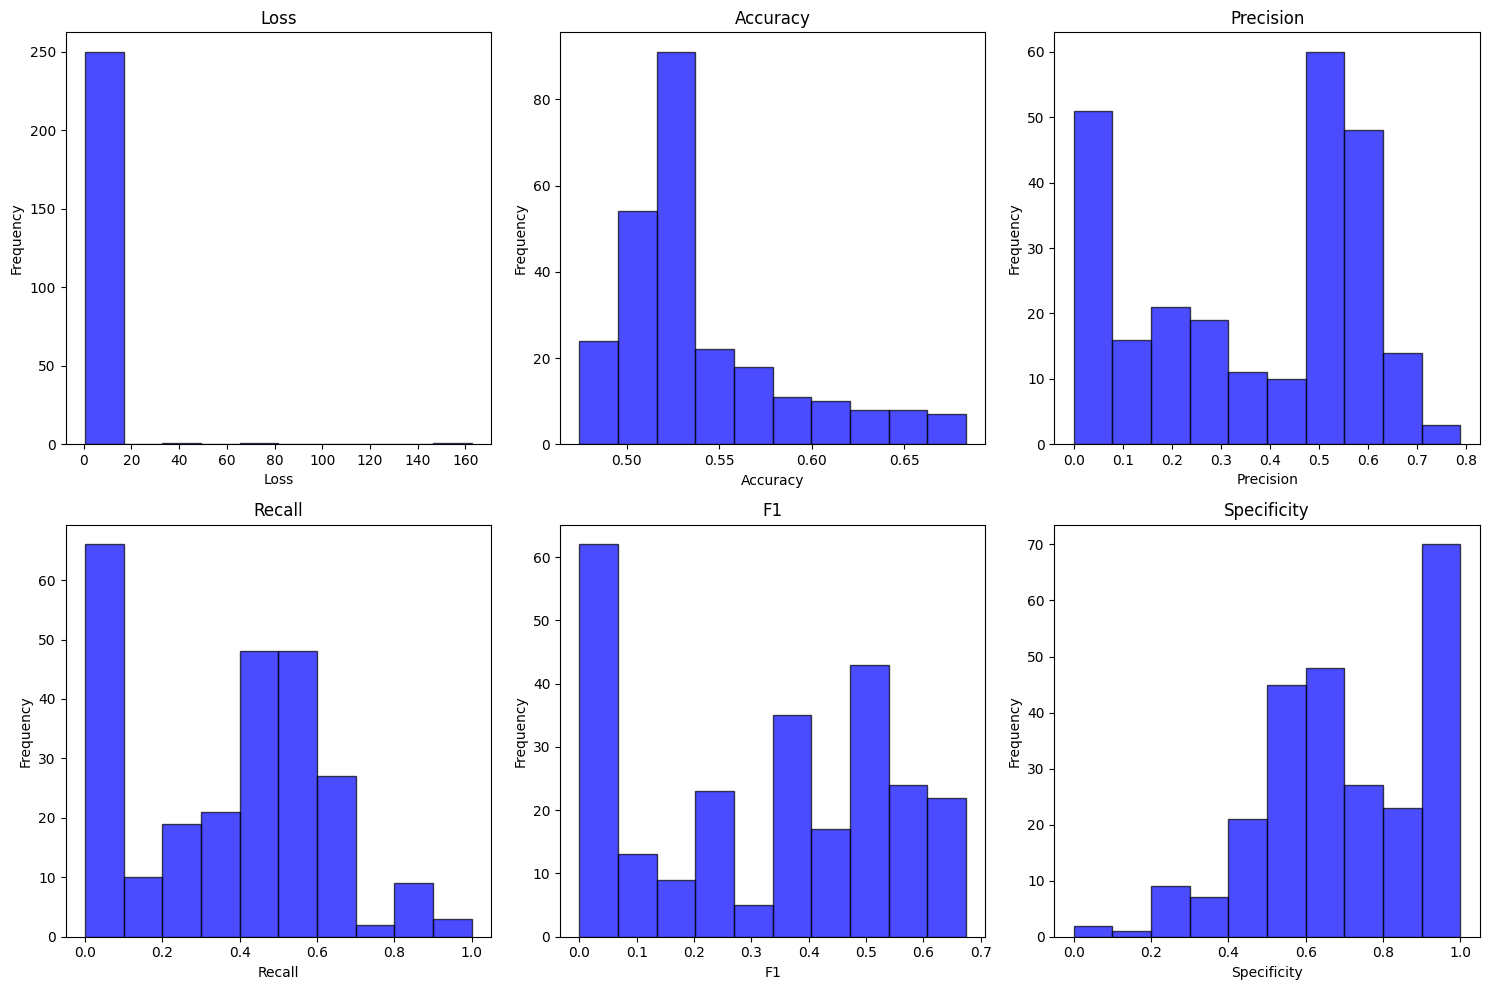

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset desde el archivo CSV
file_path = './model_results_combined.csv'
df = pd.read_csv(file_path)

# Especificar las métricas a graficar
metrics = ["Loss", "Accuracy", "Precision", "Recall", "F1", "Specificity"]

# Crear un único plot con subplots para cada métrica
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].hist(df[metric], bins=10, alpha=0.7, color="blue", edgecolor="black")
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


## Creación del modelo

## XGBoostB

In [28]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import joblib
import pandas as pd

# Cargar los datos
data = pd.read_csv('./model_results_combined.csv')

# Convertir la columna 'Encoded Architecture' de strings a listas de enteros
data['Encoded Architecture'] = data['Encoded Architecture'].apply(eval)

# Expandir 'Encoded Architecture' en múltiples columnas
X = pd.DataFrame(data['Encoded Architecture'].tolist())
y_metrics = data[['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_metrics, test_size=0.2, random_state=42)

# Definir la métrica de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Espacios de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Diccionario para almacenar los resultados
results = {}

# Optimización y evaluación para cada métrica en y_metrics
for metric in y_metrics.columns:
    print(f"\nOptimización del modelo para {metric}...")

    # Crear modelo base
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=scorer, 
        cv=10, 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train[metric])
    best_grid_model = grid_search.best_estimator_
    best_grid_score = -grid_search.best_score_
    best_grid_params = grid_search.best_params_

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist,
        n_iter=20, 
        scoring=scorer, 
        cv=10, 
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train[metric])
    best_random_model = random_search.best_estimator_
    best_random_score = -random_search.best_score_
    best_random_params = random_search.best_params_

    print(f"\nResultados para {metric} - GridSearchCV:")
    print(f"Mejor MSE: {best_grid_score}")
    print(f"Mejores hiperparámetros: {best_grid_params}")

    print(f"\nResultados para {metric} - RandomizedSearchCV:")
    print(f"Mejor MSE: {best_random_score}")
    print(f"Mejores hiperparámetros: {best_random_params}")
    
    # Evaluación del mejor modelo de cada método
    for search_type, best_model, best_params, best_score in [
        ("GridSearchCV", best_grid_model, best_grid_params, best_grid_score),
        ("RandomizedSearchCV", best_random_model, best_random_params, best_random_score)
    ]:
        # Predecir en el conjunto de prueba
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test[metric], y_pred)
        variance = np.var(y_test[metric] - y_pred)

        # Almacenar resultados
        results[(metric, search_type)] = {
            'best_score': best_score,
            'best_params': best_params,
            'test_mse': mse,
            'variance': variance,
            'real_values': y_test[metric].values,
            'predicted_values': y_pred
        }

        # Guardar el modelo optimizado en disco
        joblib.dump(best_model, f"{metric}_{search_type}_optimized_surrogate_model.pkl")

# Crear una tabla resumen con los resultados de MSE y varianza
summary = []
for (metric, search_type), result in results.items():
    summary.append({
        'Metric': metric,
        'Search Type': search_type,
        'Best Score (Cross-Validated)': result['best_score'],
        'Test MSE': result['test_mse'],
        'Variance': result['variance'],
        'Best Params': result['best_params']
    })

summary_df = pd.DataFrame(summary)

print("\nResumen de los resultados de optimización:")
print(summary_df)

# Visualizar las predicciones reales y esperadas para cada métrica en el conjunto de prueba
for (metric, search_type), result in results.items():
    print(f"\nPredicciones para {metric} ({search_type}):")
    comparison_df = pd.DataFrame({
        'Real': result['real_values'],
        'Predicted': result['predicted_values']
    })
    print(comparison_df.head())
    print(f"Varianza de las predicciones para {metric}: {result['variance']}")
    print(f"MSE en el conjunto de prueba para {metric}: {result['test_mse']}")



Optimización del modelo para Loss...

Resultados para Loss - GridSearchCV:
Mejor MSE: 160.4118073964035
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}

Resultados para Loss - RandomizedSearchCV:
Mejor MSE: 168.67028806564804
Mejores hiperparámetros: {'subsample': 0.6, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Optimización del modelo para Accuracy...

Resultados para Accuracy - GridSearchCV:
Mejor MSE: 0.0019819508336577077
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}

Resultados para Accuracy - RandomizedSearchCV:
Mejor MSE: 0.0019430111483615415
Mejores hiperparámetros: {'subsample': 0.6, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Optimización del modelo para Precision...

Resultados para Precision - GridSearchCV:
Mejor MSE: 0.046410055

### PRobar aleatorios

In [29]:
import numpy as np
import joblib
import pandas as pd

# Cargar los modelos ganadores para cada métrica
metric_models = {}
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']

for metric in metrics:
    metric_models[metric] = joblib.load(f"{metric}_best_model.pkl")

# Lista para almacenar resultados de predicciones
results = []

# Generar 10 arquitecturas y predecir métricas para cada una usando los modelos ganadores
for i in range(10):
    print(f"\nGenerando arquitectura {i+1}...")
    
    # Generar una arquitectura de ejemplo
    model_dict = generate_random_architecture()
    encoded_model = encode_model_architecture(model_dict, max_alleles=48)
    fixed_model = fixArch(encoded_model, verbose=False)
    
    # Preparar arquitectura para predicción
    example_architecture = np.array(fixed_model).reshape(1, -1)
    print(f"Arquitectura de ejemplo: {example_architecture}")
    
    # Predicciones para cada métrica usando el modelo ganador correspondiente
    predictions = {'Architecture': fixed_model}
    for metric, model in metric_models.items():
        predicted_value = model.predict(example_architecture)[0]
        predictions[metric] = predicted_value
        print(f"Predicción de {metric} para la arquitectura {i+1}: {predicted_value}")
    
    # Agregar predicciones al conjunto de resultados
    results.append(predictions)

# Crear un DataFrame de pandas con los resultados
df_results = pd.DataFrame(results)
print("\nTabla de predicciones para las 10 arquitecturas generadas:")
df_results



Generando arquitectura 1...


NameError: name 'generate_random_architecture' is not defined

### Metricas de comparacion

In [30]:
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los resultados reales del CSV de experimentos completados
real_results = pd.read_csv('experiment_results.csv')

# Filtrar los resultados reales para considerar solo Splits=10, Epochs=50, y Window Size=5
filtered_real_results = real_results[
    (real_results['Splits'] == 10) &
    (real_results['Epochs'] == 50) &
    (real_results['Window Size'] == 5)
]

# Renombrar la columna F1-score para coincidir con las métricas de los modelos predichos
filtered_real_results.rename(columns={'F1-score': 'F1'}, inplace=True)

# Cargar los modelos ganadores para cada métrica
metric_models = {}
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
for metric in metrics:
    metric_models[metric] = joblib.load(f"{metric}_best_model.pkl")

# Diccionario de modelos a verificar
models_to_test = {
    "CNN_LF": model_CNN_LF,
    "reduced_model": model_reduced,
    "Spectro_CNN": model_spectro_CNN,
}

# Lista para almacenar predicciones
predictions = []

# Generar predicciones usando los modelos ganadores
for model_name, model_architecture in models_to_test.items():
    # Codificar el modelo
    encoded_architecture = encode_model_architecture(model_architecture, max_alleles=48)
    fixed_architecture = fixArch(encoded_architecture, verbose=False)
    example_architecture = np.array(fixed_architecture).reshape(1, -1)

    # Predicciones para cada métrica
    pred_result = {'Architecture': model_name}
    for metric, model in metric_models.items():
        predicted_value = model.predict(example_architecture)[0]
        pred_result[metric] = predicted_value
    
    # Agregar predicciones a la lista
    predictions.append(pred_result)

# Convertir predicciones en DataFrame
df_predictions = pd.DataFrame(predictions)

# Combinar los resultados reales filtrados y las predicciones para el análisis comparativo
df_comparison = pd.merge(filtered_real_results, df_predictions, on='Architecture', suffixes=('_real', '_pred'))

# Crear un DataFrame para mostrar tanto el valor real como el predicho lado a lado
comparative_columns = []
for metric in metrics:
    comparative_columns.extend([f"{metric}_real", f"{metric}_pred"])

df_comparison = df_comparison[['Architecture'] + comparative_columns]

# Calcular métricas de evaluación para cada métrica de rendimiento
comparison_metrics = []
for metric in metrics:
    real_values = df_comparison[f"{metric}_real"]
    predicted_values = df_comparison[f"{metric}_pred"]
    
    mse = mean_squared_error(real_values, predicted_values)
    mae = mean_absolute_error(real_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((real_values - predicted_values) / real_values)) * 100
    r2 = r2_score(real_values, predicted_values)
    
    comparison_metrics.append({
        'Metric': metric,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R^2': r2
    })

# Crear DataFrame de métricas comparativas
df_comparison_metrics = pd.DataFrame(comparison_metrics)

# Mostrar los resultados
print("\nTabla de comparación de valores reales y predichos para cada métrica:")
df_comparison



Final Encoded Model: [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0]
Final Encoded Model: [1, 0, 0, 0, 0, 16, 0, 1, 1, 0, 0, 0, 0, 8, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 32, 1, 0, 4, 1, 2, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0]
Final Encoded Model: [0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 2, 1, 0, 0, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0]

Tabla de comparación de valores reales y predichos para cada métrica:


C:\Users\herna\AppData\Local\Temp\ipykernel_29240\1652941432.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_real_results.rename(columns={'F1-score': 'F1'}, inplace=True)


,Architecture,Loss_real,Loss_pred,Accuracy_real,Accuracy_pred,Precision_real,Precision_pred,Recall_real,Recall_pred,F1_real,F1_pred,Specificity_real,Specificity_pred
0,CNN_LF,0.632090,0.699695,0.642190,0.592257,0.624062,0.587493,0.641503,0.528170,0.627572,0.555603,0.642811,0.709816
1,reduced_model,0.591232,0.694706,0.721986,0.554277,0.712174,0.171354,0.696422,0.386462,0.703932,0.293116,0.745073,0.723047
2,Spectro_CNN,0.690102,2.712997,0.539983,0.647516,0.525948,0.654398,0.272809,0.636921,0.354037,0.607360,0.781260,0.748112


In [32]:
print("\nMétricas de evaluación entre predicciones y valores reales:")
df_comparison_metrics



Métricas de evaluación entre predicciones y valores reales:


,Metric,MSE,MAE,RMSE,MAPE (%),R^2
0,Loss,1.369128,0.731325,1.170097,107.108996,-831.013203
1,Accuracy,0.014061,0.108392,0.118579,16.972862,-1.534087
2,Precision,0.103441,0.235280,0.321622,35.407229,-16.879213
3,Recall,0.080499,0.262468,0.283723,65.214072,-1.275412
4,F1,0.079374,0.245370,0.281734,47.127025,-2.517677
5,Specificity,0.002025,0.040726,0.044995,5.874247,0.411003


## SVM

In [24]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import joblib
import pandas as pd

# Cargar los datos
print("Cargando los datos...")
data = pd.read_csv('./model_results_combined.csv')
print(f"Datos cargados. Número de filas: {data.shape[0]}, columnas: {data.shape[1]}")

# Convertir la columna 'Encoded Architecture' de strings a listas de enteros
print("Procesando la columna 'Encoded Architecture'...")
data['Encoded Architecture'] = data['Encoded Architecture'].apply(eval)

# Expandir 'Encoded Architecture' en múltiples columnas
print("Expandiendo 'Encoded Architecture' en columnas separadas...")
X = pd.DataFrame(data['Encoded Architecture'].tolist())
y_metrics = data[['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']]

# Dividir los datos en conjuntos de entrenamiento y prueba
print("Dividiendo datos en conjuntos de entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(X, y_metrics, test_size=0.2, random_state=42)
print(f"Datos divididos: {X_train.shape[0]} para entrenamiento, {X_test.shape[0]} para prueba.")

# Definir la métrica de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Espacios de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Diccionario para almacenar los resultados
results = {}

# Optimización y evaluación para cada métrica en y_metrics
for metric in y_metrics.columns:
    print(f"\nOptimización del modelo para {metric}...")

    # Crear modelo base
    model = SVR()

    # GridSearchCV
    print(f"Comenzando GridSearchCV para {metric}...")
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=scorer, 
        cv=5, 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train[metric])
    print(f"GridSearchCV completado para {metric}.")
    best_grid_model = grid_search.best_estimator_
    best_grid_score = -grid_search.best_score_
    best_grid_params = grid_search.best_params_

    # RandomizedSearchCV
    print(f"Comenzando RandomizedSearchCV para {metric}...")
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist,
        n_iter=10, 
        scoring=scorer, 
        cv=5, 
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train[metric])
    print(f"RandomizedSearchCV completado para {metric}.")
    best_random_model = random_search.best_estimator_
    best_random_score = -random_search.best_score_
    best_random_params = random_search.best_params_

    print(f"\nResultados para {metric} - GridSearchCV:")
    print(f"Mejor MSE: {best_grid_score}")
    print(f"Mejores hiperparámetros: {best_grid_params}")

    print(f"\nResultados para {metric} - RandomizedSearchCV:")
    print(f"Mejor MSE: {best_random_score}")
    print(f"Mejores hiperparámetros: {best_random_params}")
    
    # Evaluación del mejor modelo de cada método
    for search_type, best_model, best_params, best_score in [
        ("GridSearchCV", best_grid_model, best_grid_params, best_grid_score),
        ("RandomizedSearchCV", best_random_model, best_random_params, best_random_score)
    ]:
        print(f"Evaluando el modelo {search_type} para {metric}...")
        # Predecir en el conjunto de prueba
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test[metric], y_pred)
        variance = np.var(y_test[metric] - y_pred)

        # Almacenar resultados
        results[(metric, search_type)] = {
            'best_score': best_score,
            'best_params': best_params,
            'test_mse': mse,
            'variance': variance,
            'real_values': y_test[metric].values,
            'predicted_values': y_pred
        }
        print(f"Evaluación completada. Test MSE: {mse}, Varianza: {variance}")

        # Guardar el modelo optimizado en disco
        model_path = f"{metric}_{search_type}_optimized_svm_model.pkl"
        joblib.dump(best_model, model_path)
        print(f"Modelo guardado en {model_path}")

# Crear una tabla resumen con los resultados de MSE y varianza
print("\nCreando tabla resumen de resultados...")
summary = []
for (metric, search_type), result in results.items():
    summary.append({
        'Metric': metric,
        'Search Type': search_type,
        'Best Score (Cross-Validated)': result['best_score'],
        'Test MSE': result['test_mse'],
        'Variance': result['variance'],
        'Best Params': result['best_params']
    })

summary_df = pd.DataFrame(summary)

print("\nResumen de los resultados de optimización:")
print(summary_df)

# Visualizar las predicciones reales y esperadas para cada métrica en el conjunto de prueba
for (metric, search_type), result in results.items():
    print(f"\nPredicciones para {metric} ({search_type}):")
    comparison_df = pd.DataFrame({
        'Real': result['real_values'],
        'Predicted': result['predicted_values']
    })
    print(comparison_df.head())
    print(f"Varianza de las predicciones para {metric}: {result['variance']}")
    print(f"MSE en el conjunto de prueba para {metric}: {result['test_mse']}")


Cargando los datos...
Datos cargados. Número de filas: 253, columnas: 7
Procesando la columna 'Encoded Architecture'...
Expandiendo 'Encoded Architecture' en columnas separadas...
Dividiendo datos en conjuntos de entrenamiento y prueba...
Datos divididos: 202 para entrenamiento, 51 para prueba.

Optimización del modelo para Loss...
Comenzando GridSearchCV para Loss...
GridSearchCV completado para Loss.
Comenzando RandomizedSearchCV para Loss...
RandomizedSearchCV completado para Loss.

Resultados para Loss - GridSearchCV:
Mejor MSE: 153.95743002764573
Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Resultados para Loss - RandomizedSearchCV:
Mejor MSE: 153.58981711348787
Mejores hiperparámetros: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Evaluando el modelo GridSearchCV para Loss...
Evaluación completada. Test MSE: 20.36157971693898, Varianza: 20.156629009899937
Modelo guardado en Loss_GridSearchCV_optimized_svm_model.pkl
Evaluando el modelo RandomizedSearchCV pa

In [25]:
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los resultados reales del CSV de experimentos completados
real_results = pd.read_csv('experiment_results.csv')

# Filtrar los resultados reales para considerar solo Splits=10, Epochs=50, y Window Size=5
filtered_real_results = real_results[
    (real_results['Splits'] == 10) & 
    (real_results['Epochs'] == 50) & 
    (real_results['Window Size'] == 5)
]

# Renombrar la columna F1-score para coincidir con las métricas de los modelos predichos
filtered_real_results.rename(columns={'F1-score': 'F1'}, inplace=True)

# Cargar los modelos ganadores para cada métrica usando SVM
metric_models = {}
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
for metric in metrics:
    metric_models[metric] = joblib.load(f"{metric}_RandomizedSearchCV_optimized_svm_model.pkl")

# Diccionario de modelos a verificar
models_to_test = {
    "CNN_LF": model_CNN_LF,
    "reduced_model": model_reduced,
    "Spectro_CNN": model_spectro_CNN,
}

# Lista para almacenar predicciones
predictions = []

# Generar predicciones usando los modelos ganadores
for model_name, model_architecture in models_to_test.items():
    # Codificar el modelo
    encoded_architecture = encode_model_architecture(model_architecture, max_alleles=48)
    fixed_architecture = fixArch(encoded_architecture, verbose=False)
    example_architecture = np.array(fixed_architecture).reshape(1, -1)

    # Predicciones para cada métrica
    pred_result = {'Architecture': model_name}
    for metric, model in metric_models.items():
        predicted_value = model.predict(example_architecture)[0]
        pred_result[metric] = predicted_value

    # Agregar predicciones a la lista
    predictions.append(pred_result)

# Convertir predicciones en DataFrame
df_predictions = pd.DataFrame(predictions)

# Combinar los resultados reales filtrados y las predicciones para el análisis comparativo
df_comparison = pd.merge(filtered_real_results, df_predictions, on='Architecture', suffixes=('_real', '_pred'))

# Crear un DataFrame para mostrar tanto el valor real como el predicho lado a lado
comparative_columns = []
for metric in metrics:
    comparative_columns.extend([f"{metric}_real", f"{metric}_pred"])

df_comparison = df_comparison[['Architecture'] + comparative_columns]

# Calcular métricas de evaluación para cada métrica de rendimiento
comparison_metrics = []
for metric in metrics:
    real_values = df_comparison[f"{metric}_real"]
    predicted_values = df_comparison[f"{metric}_pred"]

    mse = mean_squared_error(real_values, predicted_values)
    mae = mean_absolute_error(real_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((real_values - predicted_values) / real_values)) * 100
    r2 = r2_score(real_values, predicted_values)

    comparison_metrics.append({
        'Metric': metric,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R^2': r2
    })

# Crear DataFrame de métricas comparativas
df_comparison_metrics = pd.DataFrame(comparison_metrics)

# Mostrar los resultados
print("\nTabla de comparación de valores reales y predichos para cada métrica:")
df_comparison



Final Encoded Model: [0, 30, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 16, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 5, 0, 0, 0, 4, 256, 0, 0, 3, 1, 0, 0, 4, 1, 2, 0]
Final Encoded Model: [1, 0, 0, 0, 0, 16, 0, 1, 1, 0, 0, 0, 0, 8, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 4, 32, 1, 0, 4, 1, 2, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0]
Final Encoded Model: [0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 2, 1, 0, 0, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0, 0, 32, 0, 1, 0, 32, 0, 1, 1, 0, 0, 0]

Tabla de comparación de valores reales y predichos para cada métrica:


C:\Users\herna\AppData\Local\Temp\ipykernel_29240\710707950.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_real_results.rename(columns={'F1-score': 'F1'}, inplace=True)


,Architecture,Loss_real,Loss_pred,Accuracy_real,Accuracy_pred,Precision_real,Precision_pred,Recall_real,Recall_pred,F1_real,F1_pred,Specificity_real,Specificity_pred
0,CNN_LF,0.632090,0.785702,0.642190,0.579637,0.624062,0.290149,0.641503,0.335667,0.627572,0.301104,0.642811,0.699921
1,reduced_model,0.591232,0.766005,0.721986,0.580024,0.712174,0.334388,0.696422,0.499948,0.703932,0.302669,0.745073,0.518266
2,Spectro_CNN,0.690102,0.782883,0.539983,0.578912,0.525948,0.498790,0.272809,0.497073,0.354037,0.498262,0.781260,0.725634


In [26]:
print("\nResumen de las métricas de evaluación:")
df_comparison_metrics



Resumen de las métricas de evaluación:


,Metric,MSE,MAE,RMSE,MAPE (%),R^2
0,Loss,0.020917,0.140389,0.144627,22.435889,-11.711104
1,Accuracy,0.008527,0.081148,0.092343,12.204222,-0.536771
2,Precision,0.084986,0.246286,0.291523,37.238984,-13.689345
3,Recall,0.060811,0.242192,0.246599,52.697594,-0.718899
4,F1,0.096131,0.290652,0.310051,49.920422,-3.260322
5,Specificity,0.019266,0.113181,0.138801,15.481777,-4.604997


# Synflow




In [1]:
def compute_synflow_scores(model, input_size):
    """
    Calcula el puntaje SynFlow de un modelo dado un tamaño de entrada.
    """
    # Crear una entrada ficticia (ones) del tamaño especificado
    input_tensor = tf.ones(input_size)
    
    # Registrar gradientes
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)  # Salida del modelo
        objective = tf.ones_like(output)  # Objetivo ficticio
    # Calcular gradientes
    gradients = tape.gradient(output, model.trainable_weights, output_gradients=objective)
    
    # Puntuación de SynFlow como suma de los pesos y gradientes absolutos
    scores = [tf.reduce_sum(tf.abs(w * g)) for w, g in zip(model.trainable_weights, gradients)]
    total_score = tf.reduce_sum(scores)
    
    return total_score.numpy()


In [14]:
# Reparar cada ejemplo con fixArch y luego decodificar con decode_model_architecture
repaired_and_decoded_models = []

for i, encoded_model in enumerate([encoded_model_1, encoded_model_2, encoded_model_3, encoded_model_4, encoded_model_5], 1):
    # Reparar el modelo
    repaired_model = fixArch(encoded_model, verbose=True)
    # Decodificar el modelo reparado
    decoded_model = decode_model_architecture(repaired_model)
    tf_model = build_tf_model_from_dict(decoded_model, input_shape=(128, 128, 1))
    synflow_score = compute_synflow_scores(tf_model, input_size=(1, 128, 128, 1))  # Espectrograma como entrada
    print(f"SynFlow Score para el modelo {i}: {synflow_score}")
    # Guardar el modelo decodificado
    repaired_and_decoded_models.append(decoded_model)
    print(f"\n--- Modelo {i} Decodificado ---")
    print(decoded_model)

# Opcional: Mostrar todos los modelos decodificados juntos
print("\n--- Todos los Modelos Decodificados ---")
for i, model in enumerate(repaired_and_decoded_models, 1):
    print(f"Modelo {i} Decodificado:", model)



Construyendo el modelo en TensorFlow desde el JSON expandido...
SynFlow Score para el modelo 1: 0.2537357807159424

--- Modelo 1 Decodificado ---
{'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}, {'type': 'Conv2D', 'filters': 4, 'strides': 1, 'activation': 'relu'}, {'type': 'MaxPooling', 'strides': 2}, {'type': 'Dense', 'units': 2, 'activation': 'leaky_relu'}, {'type': 'DontCare'}, {'type': 'BatchNorm'}, {'type': 'Dropout', 'rate': 0.4}, {'type': 'Conv2D', 'filters': 4, 'strides': 2, 'activation': 'relu'}, {'type': 'DepthwiseConv2D', 'filters': 4, 'strides': 2, 'activation': 'relu'}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 3, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 1, 'activation': 'tanh'}, {'type': 'Dense', 'units': 1, 'activation': 'sigmoid'}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 1, 'activation': 'sigmoid'}]}

Construyendo el modelo en TensorFlow desde el JSON expandido...
SynFlow Score para el modelo 2: 0.182972311973

## Revisar significancia de synflow

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
import ast  # Para convertir la arquitectura en una lista


# Leer el dataset
dataset_path = "./model_results_combined.csv"  # Cambia esto a la ruta de tu archivo
df = pd.read_csv(dataset_path)

# Generar SynFlow y calcular correlaciones
synflow_scores = []
for idx, row in df.iterrows():
    # Convertir arquitectura de texto a lista
    encoded_architecture = ast.literal_eval(row['Encoded Architecture'])
    
    # Construir modelo desde la arquitectura
    model = decode_model_architecture(encoded_architecture)
    model = build_tf_model_from_dict(model, input_shape=(128, 128, 1))
    
    # Calcular SynFlow
    synflow_score = compute_synflow_scores(model, input_size=(1, 128, 128, 1))
    synflow_scores.append(synflow_score)

# Agregar SynFlow al dataset
df['SynFlow'] = synflow_scores

# Correlaciones con métricas
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
correlations = {}
for metric in metrics:
    correlations[metric] = r2_score(df[metric], df['SynFlow'])

# Mostrar correlaciones
for metric, corr in correlations.items():
    print(f"Correlación (R²) entre SynFlow y {metric}: {corr}")

# Guardar resultados
df.to_csv("./dataset_with_synflow.csv", index=False)
print("Dataset actualizado con SynFlow guardado como 'dataset_with_synflow.csv'")



Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo e

Correlaciones entre SynFlow y métricas:
        Metric            R2   Pearson  Spearman   Kendall
0         Loss -3.801236e+01  0.024696 -0.185151 -0.124914
1     Accuracy -2.484689e+06  0.226056  0.259043  0.177904
2    Precision -9.009282e+04  0.146625  0.229775  0.156896
3       Recall -7.438618e+04  0.156612  0.170583  0.120625
4           F1 -9.880762e+04  0.166682  0.199048  0.135882
5  Specificity -9.569264e+04 -0.076106 -0.034197 -0.021193


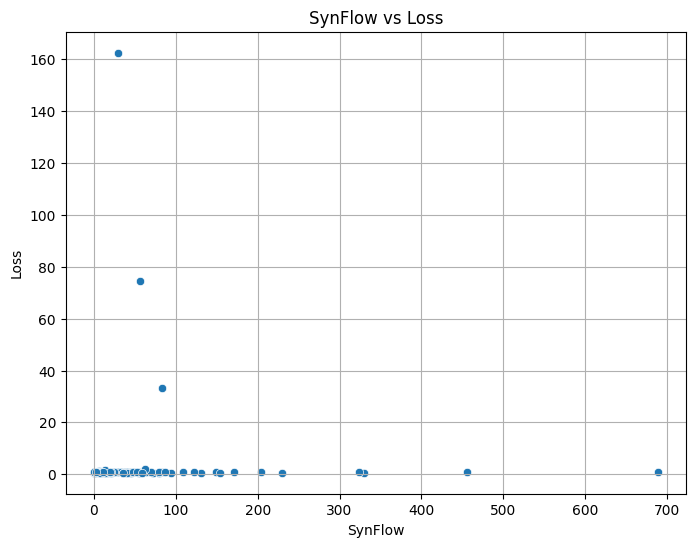

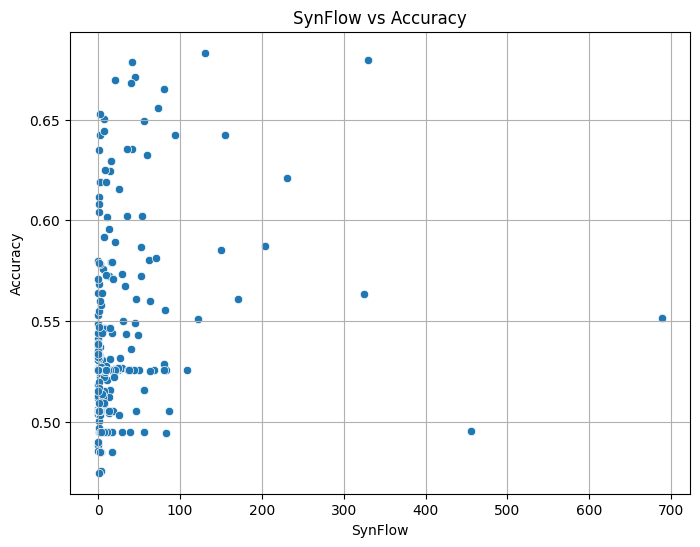

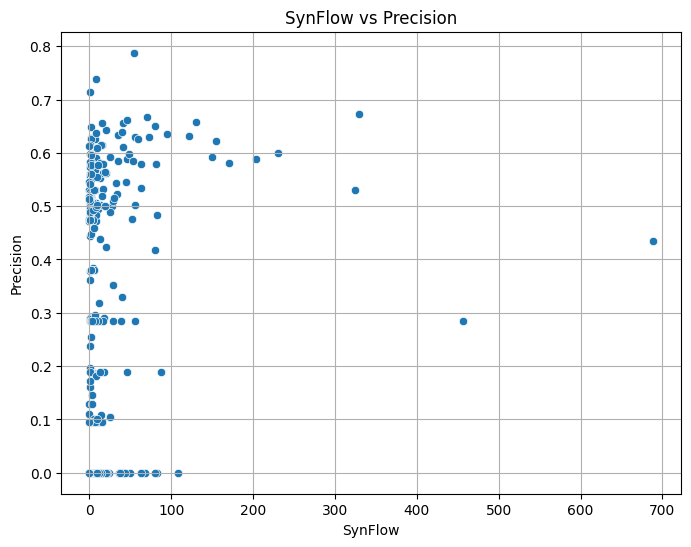

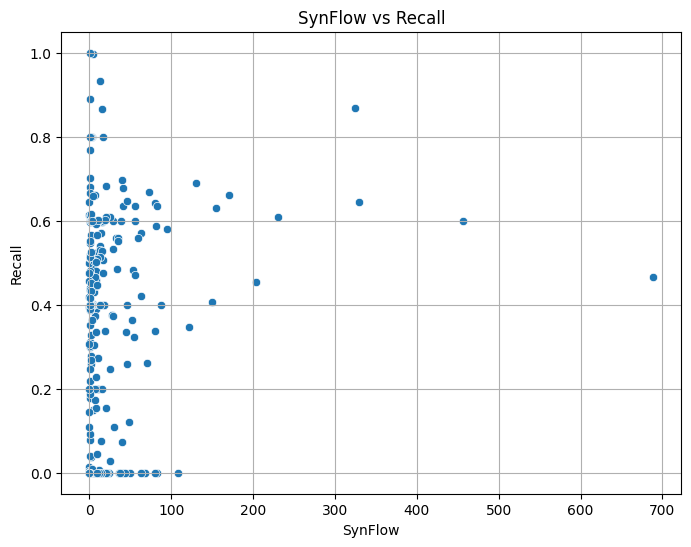

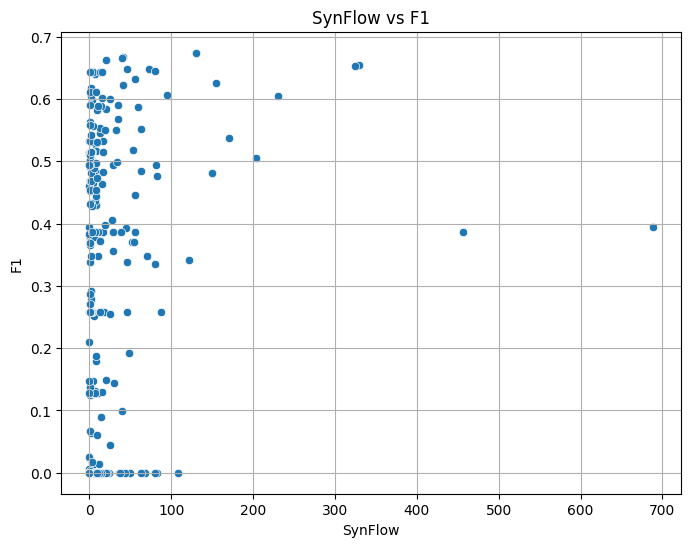

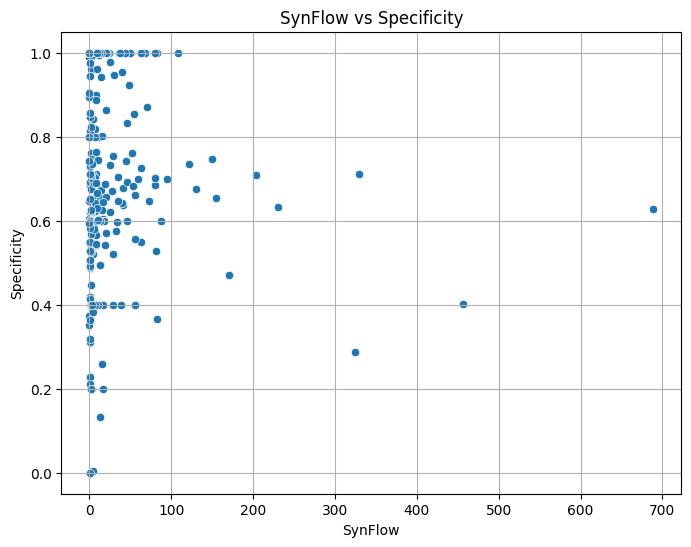

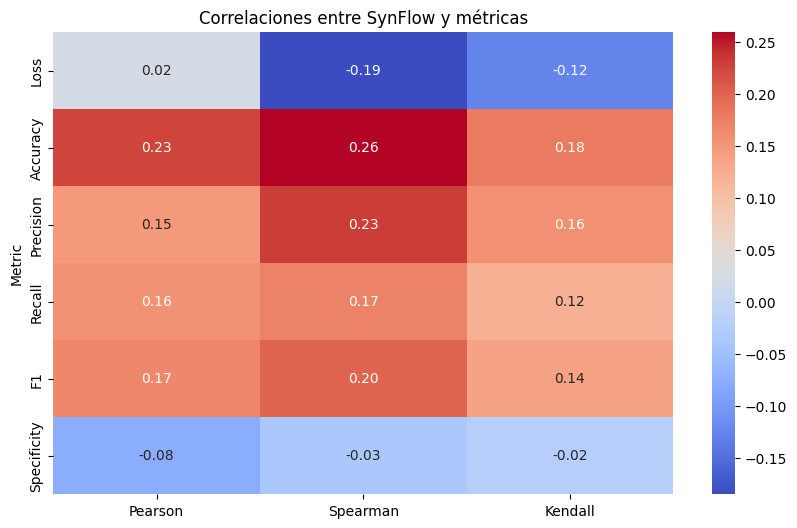

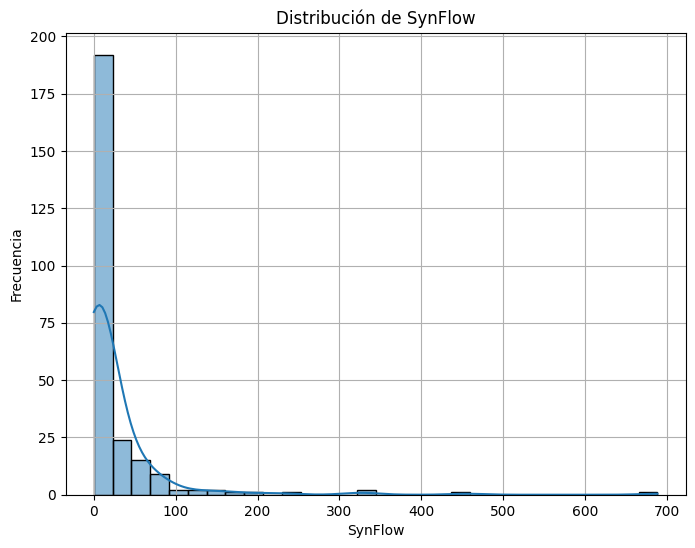

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import r2_score

# Función para calcular todas las métricas de correlación
def compute_correlations(x, y):
    r2 = r2_score(y, x)
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    kendall_corr, _ = kendalltau(x, y)
    return r2, pearson_corr, spearman_corr, kendall_corr

# Leer el dataset con SynFlow ya calculado
dataset_path = "dataset_with_synflow.csv"  # Cambia esto a tu ruta
df = pd.read_csv(dataset_path)

# Calcular correlaciones para cada métrica
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
correlations = []

for metric in metrics:
    r2, pearson, spearman, kendall = compute_correlations(df['SynFlow'], df[metric])
    correlations.append([metric, r2, pearson, spearman, kendall])

# Crear un DataFrame para las correlaciones
correlation_df = pd.DataFrame(correlations, columns=['Metric', 'R2', 'Pearson', 'Spearman', 'Kendall'])

# Mostrar las correlaciones
print("Correlaciones entre SynFlow y métricas:")
print(correlation_df)

# Graficar las relaciones
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='SynFlow', y=metric, data=df)
    plt.title(f"SynFlow vs {metric}")
    plt.xlabel("SynFlow")
    plt.ylabel(metric)
    plt.grid()
    plt.show()

# Graficar un heatmap de las correlaciones
plt.figure(figsize=(10, 6))
heatmap_data = correlation_df.set_index('Metric').drop(columns='R2')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlaciones entre SynFlow y métricas")
plt.show()

# Histogramas de SynFlow
plt.figure(figsize=(8, 6))
sns.histplot(df['SynFlow'], kde=True, bins=30)
plt.title("Distribución de SynFlow")
plt.xlabel("SynFlow")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()
